# Orders Data Analysis at DMA Level

This notebook analyzes order data grouped at the Designated Market Area (DMA) level.

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import sys
import os

# Set up plotting
plt.style.use('ggplot')
sns.set(style="whitegrid")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

## 1. Load the Orders Data

In [12]:
# Load orders data
orders_df = pd.read_csv('../raw_data/orders.csv', dtype={'postal_code': str})

# Display the first few rows
print(f"Total orders records: {len(orders_df)}")
orders_df.head()

Total orders records: 17652


,sign_date,postal_code,city,households_signed_utc
0,2/18/2025,NaN,NaN,1
1,2/18/2025,03060,Nashua,1
2,2/18/2025,06370,Montville,1
3,2/18/2025,21209,Baltimore,1
4,2/18/2025,32792,Winter Park,1


In [13]:
# Check for missing values
print("Missing values in each column:")
orders_df.isnull().sum()

Missing values in each column:


sign_date                 0
postal_code              94
city                     94
households_signed_utc     0
dtype: int64

In [14]:
# Check data types
orders_df.dtypes

sign_date                object
postal_code              object
city                     object
households_signed_utc     int64
dtype: object

In [15]:
# Convert date to datetime
orders_df['sign_date'] = pd.to_datetime(orders_df['sign_date'])

# Check data types again
orders_df.dtypes

sign_date                datetime64[ns]
postal_code                      object
city                             object
households_signed_utc             int64
dtype: object

## 2. Load the Geo Spine Data

In [16]:
# Load geo spine data - important to read zip_code as string to preserve leading zeros
geo_spine_df = pd.read_csv('../data/reference/geo_spine.csv', dtype={'zip_code': str})

# Display the first few rows
print(f"Total geo spine records: {len(geo_spine_df)}")
geo_spine_df.head()

Total geo spine records: 40775


,zip_code,dma_code,dma_name,city,state,state_name,geo_key_zip,geo_key_city,geo_key_dma,geo_key_state
0,11005,501,NEW YORK,FLORAL PARK,NY,New York,11005,"FLORAL PARK, NY",NEW YORK,NY
1,11010,501,NEW YORK,FRANKLIN SQUARE,NY,New York,11010,"FRANKLIN SQUARE, NY",NEW YORK,NY
2,11020,501,NEW YORK,GREAT NECK,NY,New York,11020,"GREAT NECK, NY",NEW YORK,NY
3,11021,501,NEW YORK,GREAT NECK,NY,New York,11021,"GREAT NECK, NY",NEW YORK,NY
4,11023,501,NEW YORK,GREAT NECK,NY,New York,11023,"GREAT NECK, NY",NEW YORK,NY


In [17]:
# Verify data types - especially that zip_code is string
geo_spine_df.dtypes

zip_code         object
dma_code          int64
dma_name         object
city             object
state            object
state_name       object
geo_key_zip       int64
geo_key_city     object
geo_key_dma      object
geo_key_state    object
dtype: object

In [18]:
# Check unique DMAs
print(f"Number of unique DMAs: {geo_spine_df['dma_name'].nunique()}")

# Display a sample of DMAs
geo_spine_df['dma_name'].value_counts().head(10)

Number of unique DMAs: 210


NEW YORK                     1243
WASHINGTON, DC (HAGRSTWN)     961
LOS ANGELES                   949
PHILADELPHIA                  777
BOSTON (MANCHESTER)           716
MINNEAPOLIS-ST. PAUL          712
PITTSBURGH                    608
DALLAS-FT. WORTH              586
DENVER                        562
CHICAGO                       533
Name: dma_name, dtype: int64

## 3. Join Orders to Geo Spine

In [19]:
# Join orders to geo spine on postal_code = zip_code
orders_geo_df = orders_df.merge(
    geo_spine_df,
    left_on='postal_code',
    right_on='zip_code',
    how='left'
)

# Check the join success rate
join_success_rate = (orders_geo_df['dma_name'].notna().sum() / len(orders_geo_df)) * 100
print(f"Join success rate: {join_success_rate:.2f}%")

# Display the joined data
orders_geo_df.head()

Join success rate: 99.08%


,sign_date,postal_code,city_x,households_signed_utc,zip_code,dma_code,dma_name,city_y,state,state_name,geo_key_zip,geo_key_city,geo_key_dma,geo_key_state
0,2025-02-18,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-02-18,03060,Nashua,1,03060,506.0,BOSTON (MANCHESTER),NASHUA,NH,New Hampshire,3060.0,"NASHUA, NH",BOSTON (MANCHESTER),NH
2,2025-02-18,06370,Montville,1,06370,533.0,HARTFORD & NEW HAVEN,OAKDALE,CT,Connecticut,6370.0,"OAKDALE, CT",HARTFORD & NEW HAVEN,CT
3,2025-02-18,21209,Baltimore,1,21209,512.0,BALTIMORE,BALTIMORE,MD,Maryland,21209.0,"BALTIMORE, MD",BALTIMORE,MD
4,2025-02-18,32792,Winter Park,1,32792,534.0,ORLANDO-DAYTONA BCH-MELBRN,WINTER PARK,FL,Florida,32792.0,"WINTER PARK, FL",ORLANDO-DAYTONA BCH-MELBRN,FL


In [20]:
# Check records that didn't join successfully
unmatched_orders = orders_geo_df[orders_geo_df['dma_name'].isna()]
print(f"Number of unmatched orders: {len(unmatched_orders)}")
unmatched_orders.head()

Number of unmatched orders: 163


,sign_date,postal_code,city_x,households_signed_utc,zip_code,dma_code,dma_name,city_y,state,state_name,geo_key_zip,geo_key_city,geo_key_dma,geo_key_state
0,2025-02-18,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2025-02-14,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,2025-02-13,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36,2025-02-12,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,2025-02-11,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Group Data at DMA Level

In [21]:
# Add year-month field for temporal analysis
orders_geo_df['year_month'] = orders_geo_df['sign_date'].dt.to_period('M')

# Group by DMA and calculate metrics
dma_orders = orders_geo_df.groupby('dma_name').agg(
    total_orders=('households_signed_utc', 'sum'),
    unique_cities=('city_y', 'nunique'),
    unique_zip_codes=('postal_code', 'nunique'),
    first_order_date=('sign_date', 'min'),
    last_order_date=('sign_date', 'max')
).reset_index()

# Calculate days between first and last order
dma_orders['active_days'] = (dma_orders['last_order_date'] - dma_orders['first_order_date']).dt.days

# Sort by total orders
dma_orders = dma_orders.sort_values('total_orders', ascending=False)

# Display the results
print(f"Number of DMAs with orders: {len(dma_orders)}")
dma_orders.head(10)

Number of DMAs with orders: 206


,dma_name,total_orders,unique_cities,unique_zip_codes,first_order_date,last_order_date,active_days
130,NEW YORK,1868,379,563,2022-01-02,2025-02-17,1142
165,SAN FRANCISCO-OAK-SAN JOSE,1177,88,214,2022-01-02,2025-02-17,1142
193,"WASHINGTON, DC (HAGRSTWN)",1031,116,232,2022-01-03,2025-02-17,1141
108,LOS ANGELES,1030,151,345,2022-01-01,2025-02-13,1139
168,SEATTLE-TACOMA,659,89,184,2022-01-01,2025-02-17,1143
23,BOSTON (MANCHESTER),601,196,264,2022-01-03,2025-02-18,1142
37,CHICAGO,566,121,188,2022-01-05,2025-02-18,1140
8,ATLANTA,542,64,139,2022-01-04,2025-02-17,1140
143,PHILADELPHIA,481,152,228,2022-01-05,2025-02-07,1129
49,DALLAS-FT. WORTH,449,71,168,2022-01-11,2025-02-13,1129


In [22]:
# Group by DMA and year-month to see temporal trends
dma_monthly_orders = orders_geo_df.groupby(['dma_name', 'year_month']).agg(
    monthly_orders=('households_signed_utc', 'sum')
).reset_index()

# Convert Period to string for plotting
dma_monthly_orders['year_month_str'] = dma_monthly_orders['year_month'].astype(str)

# Show sample of temporal data
dma_monthly_orders.head()

,dma_name,year_month,monthly_orders,year_month_str
0,ABILENE-SWEETWATER,2022-01,1,2022-01
1,ABILENE-SWEETWATER,2022-10,1,2022-10
2,ABILENE-SWEETWATER,2023-05,1,2023-05
3,ABILENE-SWEETWATER,2023-09,1,2023-09
4,"ALBANY, GA",2022-03,2,2022-03


## 5. Data Summary and Visualization

In [23]:
# Summary statistics for DMA orders
dma_orders.describe()

,total_orders,unique_cities,unique_zip_codes,active_days
count,206.000000,206.000000,206.000000,206.000000
mean,85.063107,19.980583,34.315534,910.140777
std,207.536164,36.708471,61.993961,288.295368
min,1.000000,0.000000,1.000000,0.000000
25%,7.000000,4.000000,5.000000,824.750000
50%,19.000000,9.000000,12.000000,1041.000000
75%,55.000000,20.000000,35.750000,1108.750000
max,1868.000000,379.000000,563.000000,1144.000000


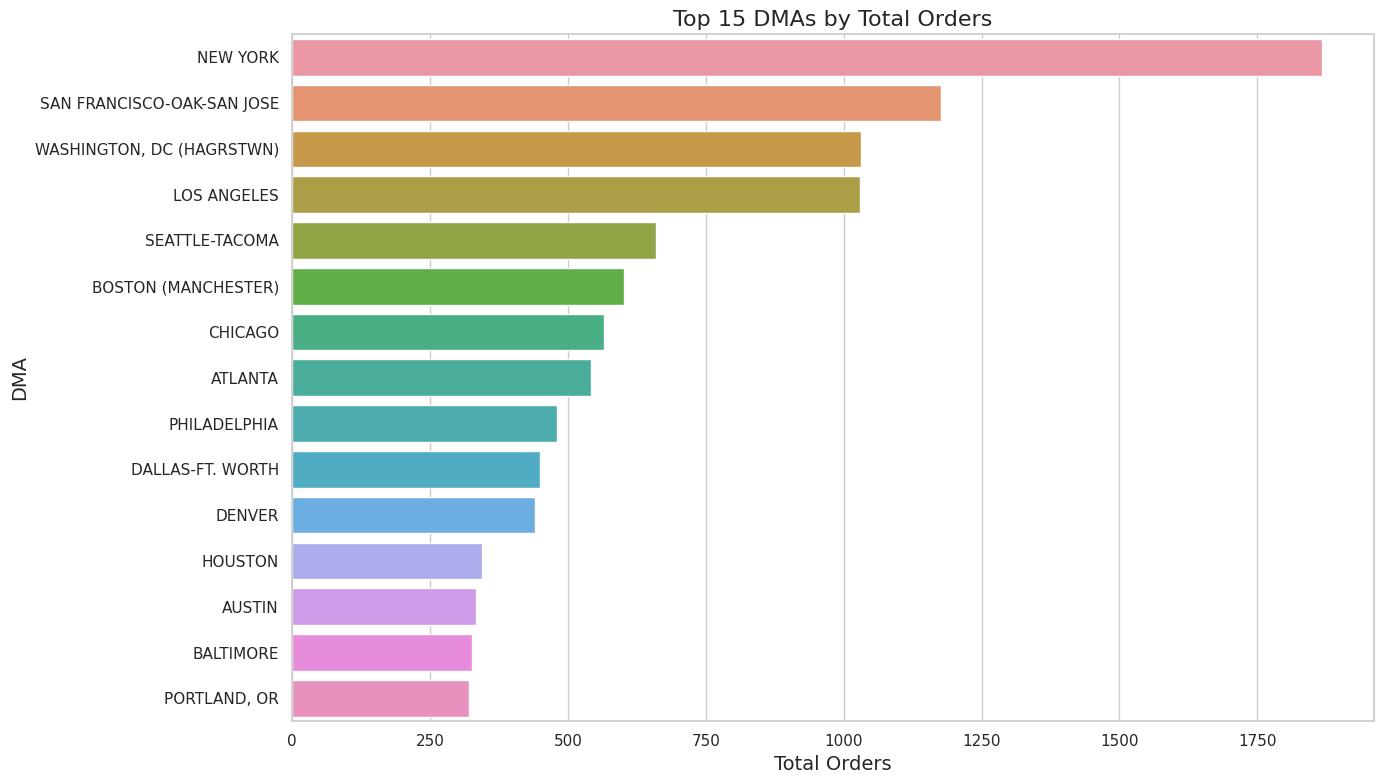

In [24]:
# Plot top 15 DMAs by total orders
plt.figure(figsize=(14, 8))
sns.barplot(x='total_orders', y='dma_name', data=dma_orders.head(15))
plt.title('Top 15 DMAs by Total Orders', fontsize=16)
plt.xlabel('Total Orders', fontsize=14)
plt.ylabel('DMA', fontsize=14)
plt.tight_layout()
plt.show()

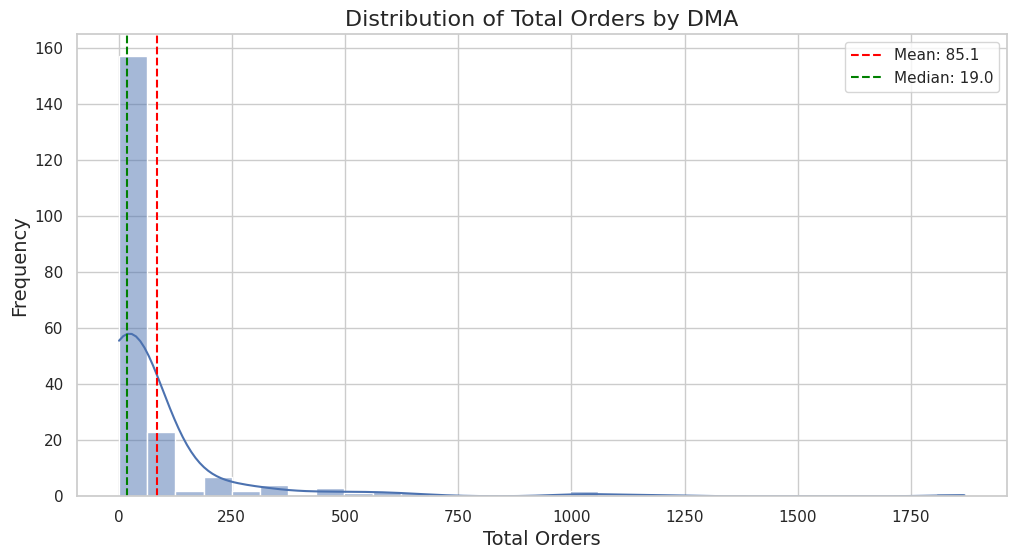

In [25]:
# Plot distribution of orders across all DMAs
plt.figure(figsize=(12, 6))
sns.histplot(dma_orders['total_orders'], bins=30, kde=True)
plt.title('Distribution of Total Orders by DMA', fontsize=16)
plt.xlabel('Total Orders', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.axvline(dma_orders['total_orders'].mean(), color='red', linestyle='--', label=f'Mean: {dma_orders["total_orders"].mean():.1f}')
plt.axvline(dma_orders['total_orders'].median(), color='green', linestyle='--', label=f'Median: {dma_orders["total_orders"].median():.1f}')
plt.legend()
plt.show()

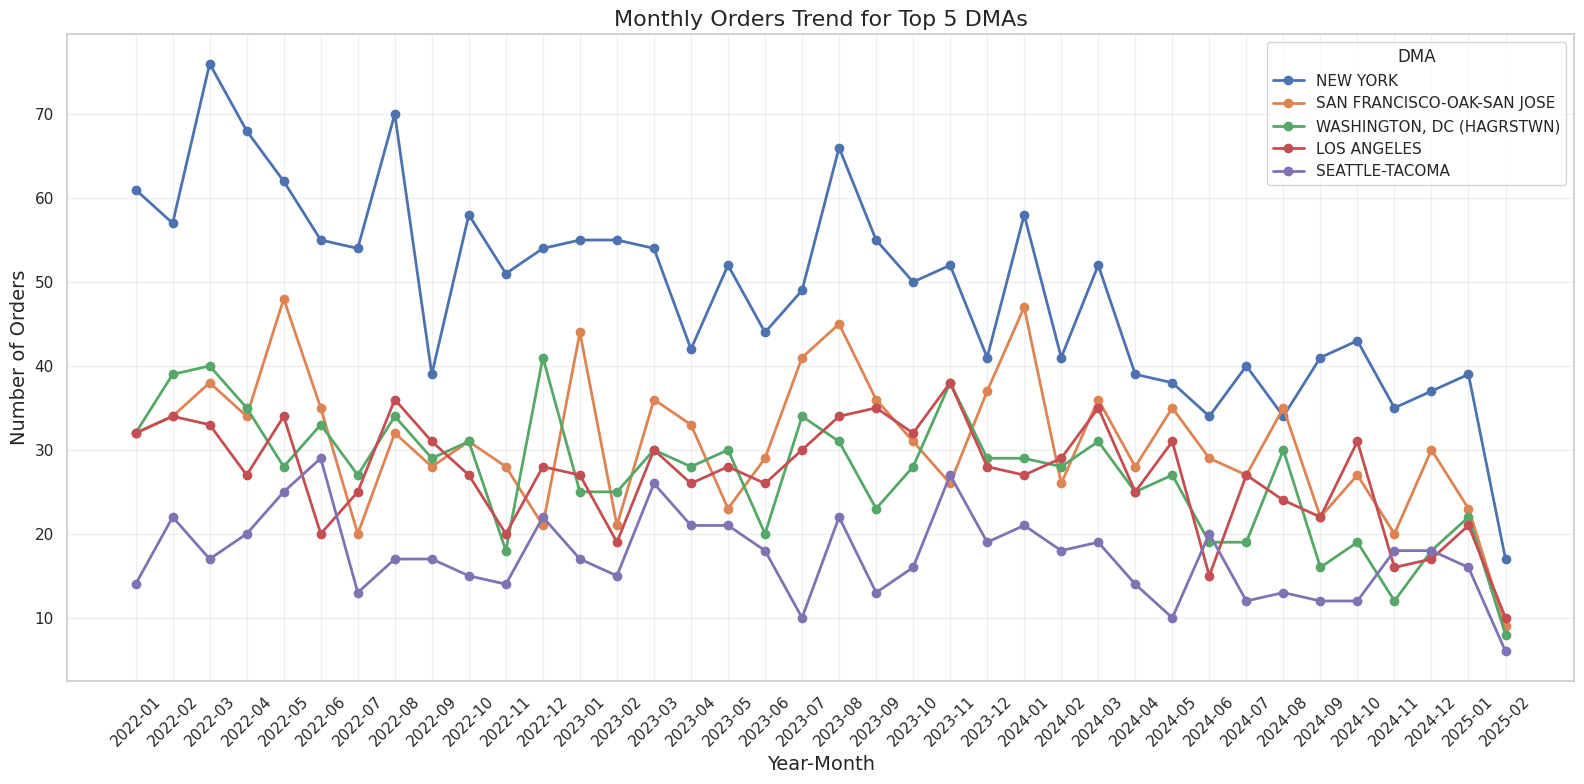

In [26]:
# Plot orders over time for top 5 DMAs
top_5_dmas = dma_orders.head(5)['dma_name'].tolist()
plt.figure(figsize=(16, 8))

for dma in top_5_dmas:
    dma_data = dma_monthly_orders[dma_monthly_orders['dma_name'] == dma]
    plt.plot(dma_data['year_month_str'], dma_data['monthly_orders'], marker='o', linewidth=2, label=dma)

plt.title('Monthly Orders Trend for Top 5 DMAs', fontsize=16)
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Number of Orders', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='DMA')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

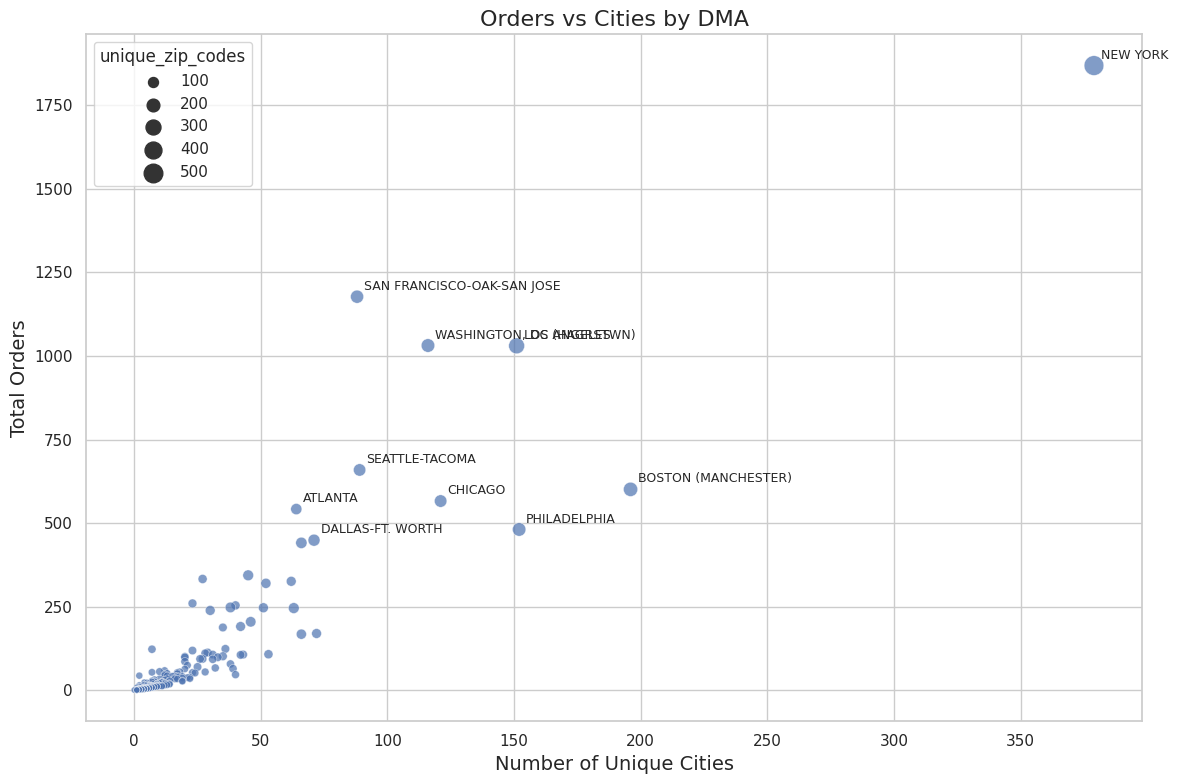

In [27]:
# Scatter plot: Number of orders vs. unique cities in each DMA
plt.figure(figsize=(12, 8))
sns.scatterplot(x='unique_cities', y='total_orders', data=dma_orders, alpha=0.7, size='unique_zip_codes', sizes=(20, 200))
plt.title('Orders vs Cities by DMA', fontsize=16)
plt.xlabel('Number of Unique Cities', fontsize=14)
plt.ylabel('Total Orders', fontsize=14)

# Annotate top DMAs
for i, row in dma_orders.head(10).iterrows():
    plt.annotate(row['dma_name'], 
                 xy=(row['unique_cities'], row['total_orders']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=9)
plt.tight_layout()
plt.show()

## 6. Key Insights and Findings

In [28]:
# Calculate market concentration metrics
total_market_orders = dma_orders['total_orders'].sum()
dma_orders['market_share'] = dma_orders['total_orders'] / total_market_orders * 100

# Calculate cumulative market share
dma_orders['cumulative_share'] = dma_orders['market_share'].cumsum()

# Top 10 DMAs market share
top_10_share = dma_orders.head(10)['market_share'].sum()
print(f"Top 10 DMAs account for {top_10_share:.1f}% of all orders")

# Find the DMAs that make up 80% of orders (Pareto principle check)
pareto_dmas = dma_orders[dma_orders['cumulative_share'] <= 80]
print(f"Number of DMAs accounting for 80% of orders: {len(pareto_dmas)}")

# Display top DMAs with their market share
dma_orders[['dma_name', 'total_orders', 'market_share', 'cumulative_share']].head(15)

Top 10 DMAs account for 48.0% of all orders
Number of DMAs accounting for 80% of orders: 39


,dma_name,total_orders,market_share,cumulative_share
130,NEW YORK,1868,10.660275,10.660275
165,SAN FRANCISCO-OAK-SAN JOSE,1177,6.716886,17.377161
193,"WASHINGTON, DC (HAGRSTWN)",1031,5.883696,23.260857
108,LOS ANGELES,1030,5.877989,29.138846
168,SEATTLE-TACOMA,659,3.760772,32.899618
23,BOSTON (MANCHESTER),601,3.429778,36.329396
37,CHICAGO,566,3.230041,39.559436
8,ATLANTA,542,3.093078,42.652514
143,PHILADELPHIA,481,2.744964,45.397478
49,DALLAS-FT. WORTH,449,2.562347,47.959824


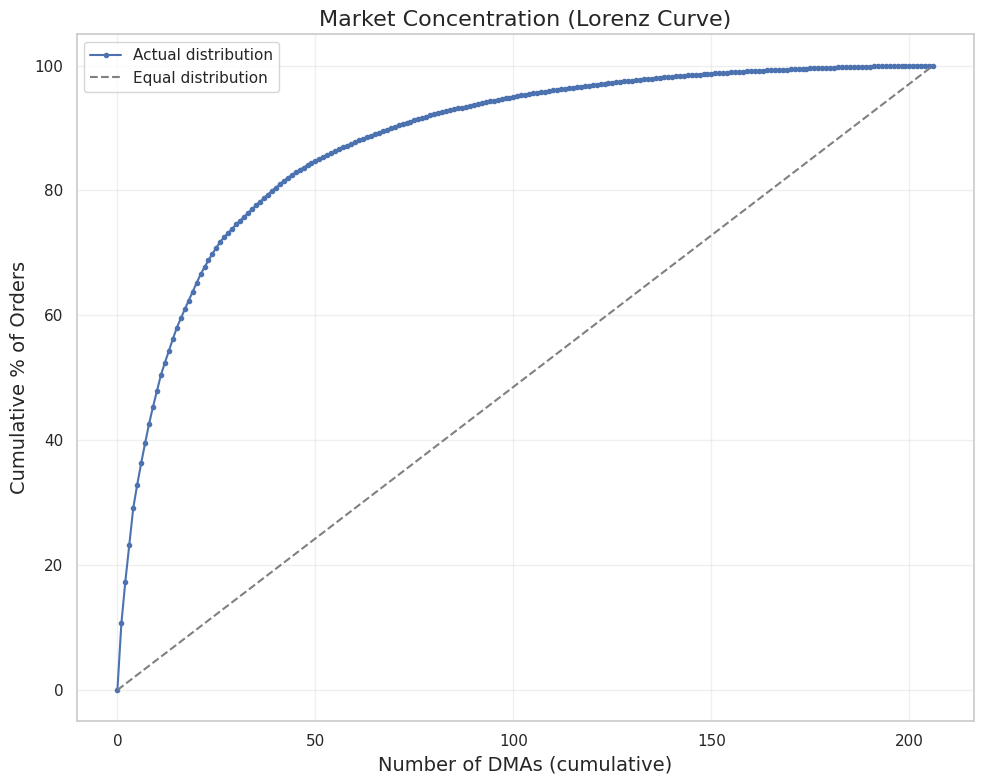

In [29]:
# Plot the Lorenz curve for market concentration
plt.figure(figsize=(10, 8))
plt.plot([0] + list(range(1, len(dma_orders) + 1)), [0] + list(dma_orders['cumulative_share']), marker='.', label='Actual distribution')
plt.plot([0, len(dma_orders)], [0, 100], linestyle='--', color='gray', label='Equal distribution')
plt.title('Market Concentration (Lorenz Curve)', fontsize=16)
plt.xlabel('Number of DMAs (cumulative)', fontsize=14)
plt.ylabel('Cumulative % of Orders', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## 7. Conclusion and Next Steps

In this analysis, we have:

1. Successfully joined the orders data with geographic reference data
2. Grouped and analyzed the data at the DMA level
3. Identified the top DMAs by order volume
4. Examined temporal trends in order activity by DMA
5. Analyzed market concentration and distribution of orders across DMAs

Next steps could include:

1. Deeper analysis of seasonal patterns by DMA
2. Correlation of order data with other metrics such as marketing spend
3. Analysis of geographic factors that might influence order patterns
4. Predictive modeling to forecast future order volumes by DMA

In [35]:
dma_orders.to_csv('dma_orders_sum.csv')